In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re # Using regular expressions for robust sorting
import random
import tensorflow as tf

data_folder = "quest_training_data/"

In [2]:
#Wanna do a quick check to see if TensorFlow can access the GPU
from tensorflow.python.client import device_lib
import tensorflow as tf

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

print(tf.__version__)

['/device:CPU:0']
2.19.0


In [11]:


# --- Seeding for reproducibility ---
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

needed_cols = [
    'TimeStamp',
    'Meta_R_Index_Distal_GLOBAL_X',
    'Meta_R_Index_Distal_GLOBAL_Y',
    'Meta_R_Index_Distal_GLOBAL_Z',
    'QTM_R_Index_Distal_GLOBAL_X',
    'QTM_R_Index_Distal_GLOBAL_Z',
    'QTM_R_Index_Distal_GLOBAL_Y',

    'Meta_R_Index_End_GLOBAL_X',
    'Meta_R_Index_End_GLOBAL_Y',
    'Meta_R_Index_End_GLOBAL_Z',
    'QTM_R_Index_End_GLOBAL_X',
    'QTM_R_Index_End_GLOBAL_Y',
    'QTM_R_Index_End_GLOBAL_Z',
    'KeyPressFlag',
    'Pressed_Letter'
]

# --- Configuration ---
data_folder = "quest_training_data/"

# --- This list will hold the final, clean DataFrames for each session ---
all_session_dfs = []

print("Starting Smart Data Concatenation (per participant)...")

# --- Discover Participant Folders ---
try:
    participant_folders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
except FileNotFoundError:
    print(f"ERROR: The directory '{data_folder}' was not found. Please check the path.")
    participant_folders = []

print(f"Found {len(participant_folders)} participant folders to process.\n")

# --- Main Processing Loop (Iterating through each participant) ---
for folder_path in participant_folders:
    participant_id = os.path.basename(folder_path)
    print(f"--- Processing Participant: {participant_id} ---")

    search_pattern = os.path.join(folder_path, '*.csv')
    csv_files = glob.glob(search_pattern)

    if not csv_files:
        print("  -> No CSV files found, skipping.\n")
        continue

    # --- Sort files chronologically using the timestamp in the filename ---
    def get_sort_key(filepath):
        matches = re.findall(r'(\d+\.\d+)\.csv', os.path.basename(filepath))
        return float(matches[-1]) if matches else 0

    csv_files.sort(key=get_sort_key)

    # Concatenate all files FOR THIS PARTICIPANT ONLY
    session_dfs = [pd.read_csv(file, usecols=needed_cols, low_memory=False) for file in csv_files]
    if session_dfs:
        session_df = pd.concat(session_dfs, ignore_index=True)
        all_session_dfs.append(session_df)
        print(f"  -> Success! Created a session DataFrame with shape: {session_df.shape}")


print("\n--- Smart Concatenation Complete ---")
print(f"Processed {len(all_session_dfs)} total sessions.")



Starting Smart Data Concatenation (per participant)...
Found 1 participant folders to process.

--- Processing Participant: ptx_01_x2 ---
  -> Success! Created a session DataFrame with shape: (314614, 15)

--- Smart Concatenation Complete ---
Processed 1 total sessions.


In [12]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

# --- Feature Engineering (Applied to each session individually) ---
processed_sessions = []
for session_df in all_session_dfs:
    feature_cols = [
        'TimeStamp',
        'Meta_R_Index_Distal_GLOBAL_X',
        'Meta_R_Index_Distal_GLOBAL_Y',
        'Meta_R_Index_Distal_GLOBAL_Z',
        'QTM_R_Index_Distal_GLOBAL_X',
        'QTM_R_Index_Distal_GLOBAL_Z',
        'QTM_R_Index_Distal_GLOBAL_Y',

        'QTM_R_Index_End_GLOBAL_X',
        'QTM_R_Index_End_GLOBAL_Y',
        'QTM_R_Index_End_GLOBAL_Z',
        'Meta_R_Index_End_GLOBAL_X',
        'Meta_R_Index_End_GLOBAL_Y',
        'Meta_R_Index_End_GLOBAL_Z',
        'Pressed_Letter'
    ]
    label_col = 'KeyPressFlag'
    required_cols = feature_cols + [label_col]
    if not all(col in session_df.columns for col in required_cols):
        continue

    df = session_df[required_cols].copy()
    # Ensure monotonic timestamps and compute per-sample dt
    df = df.sort_values('TimeStamp').reset_index(drop=True)
    dts = df['TimeStamp'].diff()
    # Use a robust dt estimate (median), clamp extremes
    dt = float(np.median(dts.dropna())) if dts.notna().any() else 1/90.0
    if dt <= 0 or not np.isfinite(dt):
        dt = 1/90.0

    # SG params: tune these
    window_length = 11  # must be odd, ~0.12 s if 90 Hz
    polyorder = 3

    # For very short segments, shrink window to be valid
    if len(df) < window_length:
        window_length = max(5, len(df) // 2 * 2 + 1)  # nearest smaller odd >=5
        polyorder = min(polyorder, window_length - 2)

    for axis in ['X', 'Y', 'Z']:
        pos_col   = f'Meta_R_Index_Distal_GLOBAL_{axis}'
        vel_col   = f'vel_{axis.lower()}'
        accel_col = f'accel_{axis.lower()}'

        pos = df[pos_col].to_numpy(dtype=float)

        # Smooth position and compute derivatives with Savitzky–Golay
        pos_sg   = savgol_filter(pos, window_length=window_length, polyorder=polyorder, deriv=0, delta=dt, mode='interp')
        vel_sg   = savgol_filter(pos, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')
        accel_sg = savgol_filter(pos, window_length=window_length, polyorder=polyorder, deriv=2, delta=dt, mode='interp')

        df[pos_col] = pos_sg
        df[vel_col] = vel_sg
        df[accel_col] = accel_sg

    # Clean infinities/NaNs (SG should produce finite values, but be safe)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    processed_sessions.append(df)

# --- Combine for training ---
if processed_sessions:
    master_df = pd.concat(processed_sessions, ignore_index=True)
    print("\n--- Feature Engineering Complete (with Savitzky–Golay) ---")
    print("Shape:", master_df.shape)
else:
    print("\nNo data to process after feature engineering.")


--- Feature Engineering Complete (with Savitzky–Golay) ---
Shape: (0, 21)


Windowing

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# --- Step 1: Prepare Data for Windowing ---
feature_columns = [
    'Meta_R_Index_Distal_GLOBAL_Y', # Position Y
    'vel_y',                        # Velocity Y
    'accel_y',                      # Acceleration Y
    #'Meta_R_Index_Distal_GLOBAL_Z', # Position Z
    #'vel_z',                        # Velocity Z
    #'accel_z'                       # Acceleration Z
]

# The rest of the script adapts automatically to the new feature count
timeseries_data = master_df[['KeyPressFlag'] + feature_columns].to_numpy()

# --- Setting window size to 100 to start off with
window_size = 100

# --- Step 2: Create Time-Series Windows ---
def make_timeseries_instances(time_series, window_size):
    """Chops the data into overlapping windows."""
    X = []
    y = []
    for i in range(window_size, time_series.shape[0]):
        X.append(time_series[i-window_size:i, 1:])
        y.append(time_series[i, 0])
    return np.array(X), np.array(y).astype(int)

print("Creating time-series windows...")
X_windowed, y_windowed = make_timeseries_instances(timeseries_data, window_size)
print("Shape of X_windowed (samples, timesteps, features):", X_windowed.shape)
print("Shape of y_windowed:", y_windowed.shape)

# --- Step 3: Split and Scale the Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("\nData successfully prepared with Y and Z-axis features.")

Creating time-series windows...
Shape of X_windowed (samples, timesteps, features): (840774, 100, 3)
Shape of y_windowed: (840774,)

Data successfully prepared with Y and Z-axis features.


Building model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
# --- Step 4: Build and Train the LSTM Model ---

print("\nBuilding the LSTM model...")
model = Sequential([
    # The LSTM layer processes the sequence. input_shape is (window_size, num_features)
    LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), unroll=True, name="lstm"),
    Dropout(0.5), # Dropout helps prevent overfitting
    # The final Dense layer gives a single output (tap or no-tap)
    Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# To handle the class imbalance, calculate class weights
# This penalizes the model more for missing the rare 'tap' events
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

print("\nTraining the LSTM model... (This may take a long time)")
# EarlyStopping will stop training if the model isn't improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=150,
    batch_size=256,
    validation_split=0.2, # Use part of the training data for validation - perhaps 20% is a good start
    callbacks=[early_stopping],
    class_weight=class_weights
)


# --- Step 5: Evaluate the Final Model ---

print("\nEvaluating the final model on the test set...")
# We predict probabilities and use a threshold of 0.5 to get 0s and 1s
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nFinal LSTM Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Building the LSTM model...


c:\Users\SyMoN\.conda\envs\saad_classifier_312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model... (This may take a long time)
Epoch 1/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 315s 133ms/step - accuracy: 0.5108 - loss: 0.6926 - val_accuracy: 0.4991 - val_loss: 0.6931
Epoch 2/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 308s 127ms/step - accuracy: 0.5100 - loss: 0.6919 - val_accuracy: 0.4991 - val_loss: 0.6927
Epoch 3/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 265s 126ms/step - accuracy: 0.5117 - loss: 0.6915 - val_accuracy: 0.5115 - val_loss: 0.6913
Epoch 4/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 324s 127ms/step - accuracy: 0.5130 - loss: 0.6913 - val_accuracy: 0.5059 - val_loss: 0.6920
Epoch 5/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 267s 127ms/step - accuracy: 0.5157 - loss: 0.6911 - val_accuracy: 0.5179 - val_loss: 0.6910
Epoch 6/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 270s 128ms/step - accuracy: 0.5198 - loss: 0.6908 - val_accuracy: 0.5155 - val_loss: 0.6911
Epoch 7/150
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 272s 129ms/step - accuracy: 0.5183 - loss: 0.6907 - val_accuracy: 0.5187 - val_loss: 0.6904

Now saving the model and exporting it, before converting to onnx.

In [11]:
model.save('ltsm_tap_golay_bluh.keras')  # Save the model for later use

In [13]:
import tensorflow as tf
# Load trained model
model = tf.keras.models.load_model('ltsm_tap_golay_bluh.keras')

# Export it to a new directory
model.export('ltsm_tap_golay_bluh')

INFO:tensorflow:Assets written to: ltsm_tap_golay_bluh\assets


INFO:tensorflow:Assets written to: ltsm_tap_golay_bluh\assets


Saved artifact at 'ltsm_tap_golay_bluh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2517562915920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2517562916688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2517540668432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2517540668816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2517540668240: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
# --- NEW CELL TO GET SCALER VALUES ---
# This cell should be run AFTER the cell where you define and fit the 'scaler' object.

print("--- Scaler Values for Unity ---")
print("Copy these arrays into your C# script.\n")

# The feature_columns list must be IDENTICAL to the one used for training
# to ensure the order of mean/scale values is correct.
# The order should be: [Y_pos, Y_vel, Y_accel, Z_pos, Z_vel, Z_accel]
feature_columns = [
    'Meta_R_Index_Distal_GLOBAL_Y',
    'vel_y',
    'accel_y',
    'Meta_R_Index_Distal_GLOBAL_Z',
    'vel_z',
    'accel_z'
]

# Check if the number of features matches the scaler's learned features
if len(feature_columns) != scaler.n_features_in_:
    print(f"ERROR: Mismatch in feature count!")
    print(f"Expected {scaler.n_features_in_} features, but feature_columns has {len(feature_columns)}.")
else:
    # The mean values, formatted for C#
    print("private readonly float[] scalerMean = new float[6] {", ", ".join(f"{val:.8f}f" for val in scaler.mean_), "};")

    # The scale (standard deviation) values, formatted for C#
    print("private readonly float[] scalerScale = new float[6] {", ", ".join(f"{val:.8f}f" for val in scaler.scale_), "};")



--- Scaler Values for Unity ---
Copy these arrays into your C# script.

private readonly float[] scalerMean = new float[6] { 0.84335761f, -0.00003552f, 0.00215728f, 0.31240889f, 0.00003085f, -0.00119933f };
private readonly float[] scalerScale = new float[6] { 0.04768423f, 0.38483474f, 10.01565886f, 0.01667832f, 0.35203841f, 9.18099814f };


Moving from tap detection to letter detection. First producing a visualisation. 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load a SINGLE, representative data file ---
# Choose one of the '0deg' files you have downloaded.
# This plot works best on a continuous recording from one file.
file_path = 'quest_training_data/ptx_03_x2/0_Master_ptx_03x2_0deg_15_along_l_35_74.29.csv' 

try:
    # --- THIS IS THE FIX ---
    # We add encoding='utf-16' to handle the file format error.
    df_single_file = pd.read_csv(file_path, low_memory=False, encoding='utf-16')

    # --- Step 2: Select the relevant columns ---
    # We'll use the Z-axis for vertical position as per Maisy's advice
    plot_df = df_single_file[[
        'TimeStamp',
        'Meta_R_Index_Distal_GLOBAL_Z',
        'KeyPressFlag'
    ]].copy()

    # --- Step 3: Create the plot ---
    plt.figure(figsize=(15, 6))

    # Plot the finger's vertical position (Z-axis) over time
    plt.plot(plot_df['TimeStamp'], plot_df['Meta_R_Index_Distal_GLOBAL_Z'], label='Finger Z Position', alpha=0.8)

    # Find the exact moments where a tap occurred (KeyPressFlag == 1)
    tap_events = plot_df[plot_df['KeyPressFlag'] == 1]

    # Add a red dot on the plot for each tap event
    plt.scatter(tap_events['TimeStamp'], tap_events['Meta_R_Index_Distal_GLOBAL_Z'], 
                color='red', label='Tap Event (Ground Truth)', zorder=5, s=50)

    # --- Step 4: Make the plot clear and readable ---
    plt.xlabel('Time (seconds)')
    plt.ylabel('Finger Vertical Position (Z-axis)')
    plt.title('Finger Tapping Motion Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please update the path to one of your CSV files.")
except KeyError as e:
    print(f"ERROR: A required column was not found: {e}. Please check the column names in your CSV file.")



UnicodeError: UTF-16 stream does not start with BOM

Found 3061 distinct tap events to visualize.


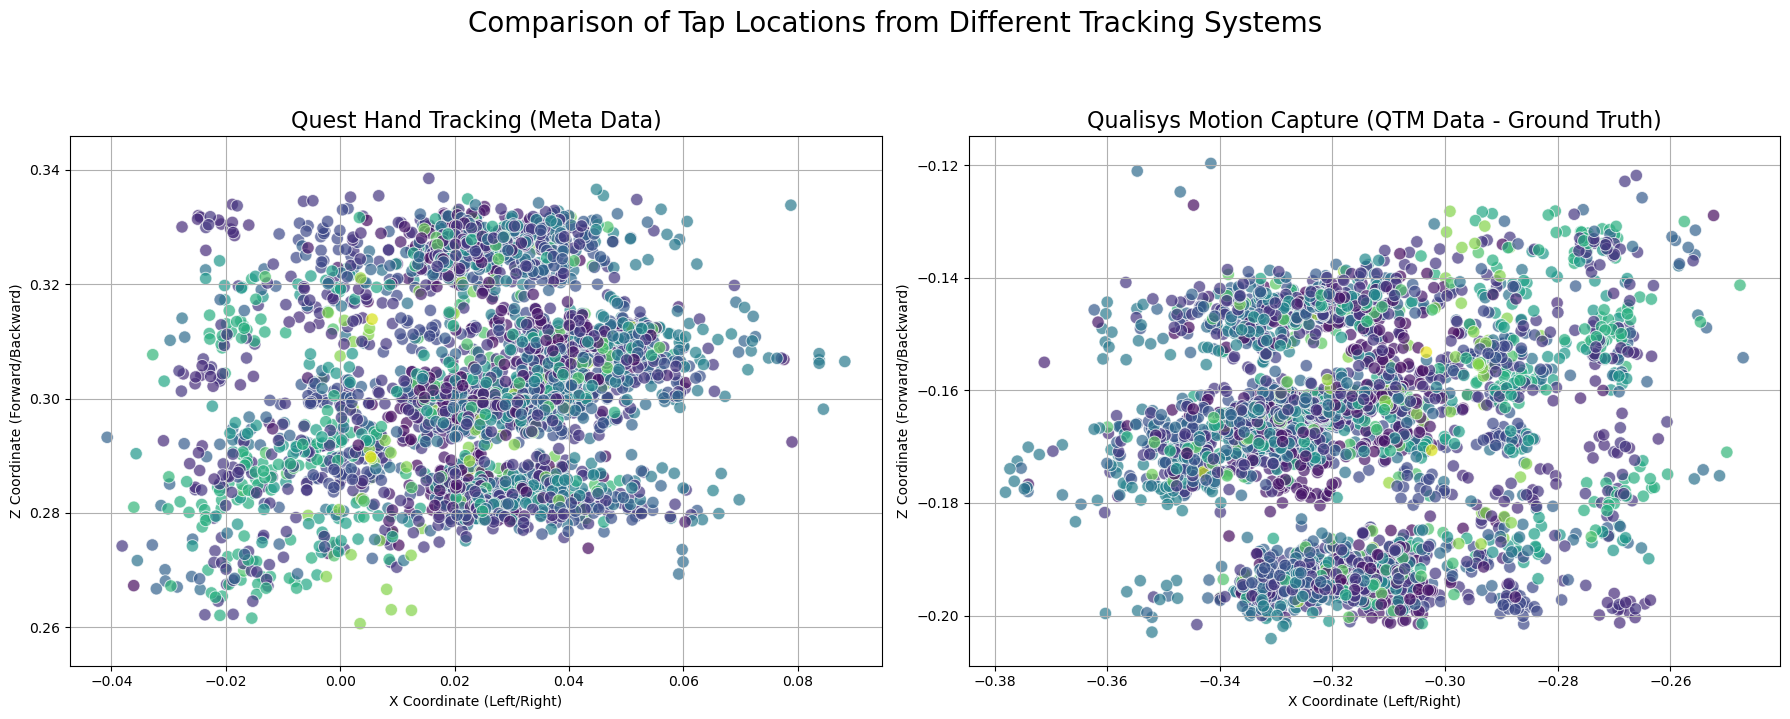

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure master_df is your fully processed dataframe from the data loading step

# --- MODIFIED SELECTION LOGIC ---
# We find the exact moment the KeyPressFlag switches from 0 to 1.
# This isolates the single, initial moment of impact for each tap.
tap_events_df = all_session_dfs[0][all_session_dfs[0]['KeyPressFlag'].diff() == 1].copy()

print(f"Found {len(tap_events_df)} distinct tap events to visualize.")

# --- Create a figure with two subplots, side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparison of Tap Locations from Different Tracking Systems', fontsize=20, y=1.02)


# --- Plot 1: Quest (Meta) Hand Tracking Data ---
sns.scatterplot(
    ax=axes[0],
    data=tap_events_df,
    x='Meta_R_Index_Distal_GLOBAL_X',
    y='Meta_R_Index_Distal_GLOBAL_Z',
    hue='Pressed_Letter',
    palette='viridis',
    s=80,
    alpha=0.7,
    legend=False
)
axes[0].set_title('Quest Hand Tracking (Meta Data)', fontsize=16)
axes[0].set_xlabel('X Coordinate (Left/Right)')
axes[0].set_ylabel('Z Coordinate (Forward/Backward)')
axes[0].grid(True)
axes[0].axis('equal')


# --- Plot 2: Qualisys (QTM) Motion Capture Data ---
# These column names correspond to the high-precision marker data for the right index fingertip
qtm_x_col = 'QTM_R_Index_Distal_GLOBAL_X'
qtm_z_col = 'QTM_R_Index_Distal_GLOBAL_Z'

# Check if the QTM columns exist in the dataframe
if qtm_x_col in tap_events_df.columns and qtm_z_col in tap_events_df.columns:
    sns.scatterplot(
        ax=axes[1],
        data=tap_events_df,
        x=qtm_x_col,
        y=qtm_z_col,
        hue='Pressed_Letter',
        palette='viridis',
        s=80,
        alpha=0.7,
        legend=False
    )
    axes[1].set_title('Qualisys Motion Capture (QTM Data - Ground Truth)', fontsize=16)
    axes[1].set_xlabel('X Coordinate (Left/Right)')
    axes[1].set_ylabel('Z Coordinate (Forward/Backward)')
    axes[1].grid(True)
    axes[1].axis('equal')
else:
    axes[1].text(0.5, 0.5, 'QTM data columns not found.', ha='center', va='center', fontsize=12)
    axes[1].set_title('Qualisys Motion Capture (Data Not Found)', fontsize=16)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Found 3061 distinct tap events to visualize in this session.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


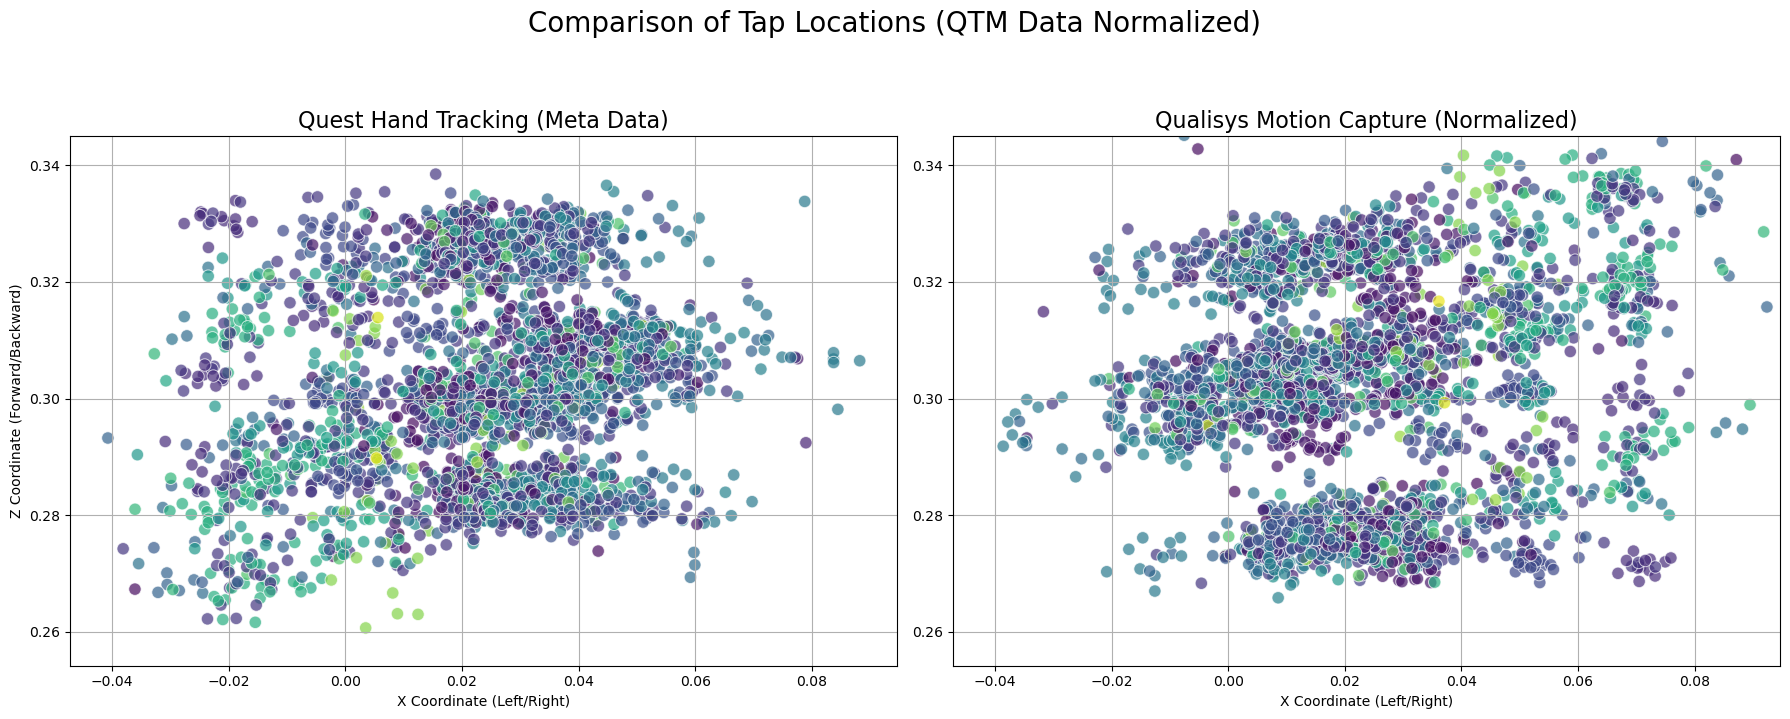

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Use the FIRST unprocessed session for a clean visualization ---
# This avoids any potential data loss from the feature engineering steps.
single_session_df = all_session_dfs[0]

# --- Isolate only the INITIAL moment of each tap ---
# We do this by finding where the KeyPressFlag switches from 0 to 1.
tap_events_df = single_session_df[single_session_df['KeyPressFlag'].diff() == 1].copy()

print(f"Found {len(tap_events_df)} distinct tap events to visualize in this session.")

# --- Normalize the QTM data to align with the Meta data for plotting ---
# 1. Define the column names
meta_x_col = 'Meta_R_Index_Distal_GLOBAL_X'
meta_z_col = 'Meta_R_Index_Distal_GLOBAL_Z'
# Note: Using 'Distal' for QTM as 'End' often contains invalid data
qtm_x_col = 'QTM_R_Index_Distal_GLOBAL_X' 
qtm_z_col = 'QTM_R_Index_Distal_GLOBAL_Z'

# Check if all necessary columns exist
if qtm_x_col in tap_events_df.columns and qtm_z_col in tap_events_df.columns:
    # 2. Calculate the center point (mean) of each dataset
    meta_center_x = tap_events_df[meta_x_col].mean()
    meta_center_z = tap_events_df[meta_z_col].mean()
    qtm_center_x = tap_events_df[qtm_x_col].mean()
    qtm_center_z = tap_events_df[qtm_z_col].mean()

    # 3. Calculate the offset needed to move the QTM center to the Meta center
    x_offset = meta_center_x - qtm_center_x
    z_offset = meta_center_z - qtm_center_z

    # 4. Apply the offset to create new, normalized QTM columns for plotting
    tap_events_df['Normalized_QTM_X'] = tap_events_df[qtm_x_col] + x_offset
    tap_events_df['Normalized_QTM_Z'] = tap_events_df[qtm_z_col] + z_offset
    
    # Update the column names we will use for plotting
    qtm_x_col_plot = 'Normalized_QTM_X'
    qtm_z_col_plot = 'Normalized_QTM_Z'
else:
    # If QTM data doesn't exist, create empty columns so the plot function doesn't fail
    qtm_x_col_plot = 'Meta_R_Index_Distal_GLOBAL_X' 
    qtm_z_col_plot = 'Meta_R_Index_Distal_GLOBAL_Z'


# --- Create a figure with two subplots, side-by-side ---
# REMOVED sharex=True and sharey=True to fix the RuntimeError
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) 
fig.suptitle('Comparison of Tap Locations (QTM Data Normalized)', fontsize=20, y=1.02)


# --- Plot 1: Quest (Meta) Hand Tracking Data ---
sns.scatterplot(
    ax=axes[0],
    data=tap_events_df,
    x=meta_x_col,
    y=meta_z_col,
    hue='Pressed_Letter',
    palette='viridis',
    s=80,
    alpha=0.7,
    legend=False
)
axes[0].set_title('Quest Hand Tracking (Meta Data)', fontsize=16)
axes[0].set_xlabel('X Coordinate (Left/Right)')
axes[0].set_ylabel('Z Coordinate (Forward/Backward)')
axes[0].grid(True)
axes[0].axis('equal')


# --- Plot 2: Qualisys (QTM) Motion Capture Data ---
if qtm_x_col in tap_events_df.columns and qtm_z_col in tap_events_df.columns:
    sns.scatterplot(
        ax=axes[1],
        data=tap_events_df,
        x=qtm_x_col_plot, # Use the new normalized column
        y=qtm_z_col_plot, # Use the new normalized column
        hue='Pressed_Letter',
        palette='viridis',
        s=80,
        alpha=0.7,
        legend=False
    )
    axes[1].set_title('Qualisys Motion Capture (Normalized)', fontsize=16)
    axes[1].set_xlabel('X Coordinate (Left/Right)')
    axes[1].set_ylabel('') # Hide Y label for clarity
    axes[1].grid(True)
    axes[1].axis('equal')
    # Set the axis limits to match the first plot for a true 1:1 comparison
    axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_ylim(axes[0].get_ylim())
else:
    axes[1].text(0.5, 0.5, 'QTM data columns not found.', ha='center', va='center', fontsize=12)
    axes[1].set_title('Qualisys Motion Capture (Data Not Found)', fontsize=16)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Visualisation : visualising thelocation of taps 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("--- Generating Model Performance Visualizations ---")

# --- 1. Plot Training & Validation Accuracy and Loss ---
# The 'history' object holds the metrics from each epoch during training
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training History', fontsize=16)
plt.show()


# --- 2. Plot a Detailed Confusion Matrix ---
# 'y_test' is the true labels, 'y_pred' is what our model predicted
cm = confusion_matrix(y_test, y_pred)

# For better visualization, we can show percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# The labels for our matrix
labels = ['True Neg (No Tap)', 'False Pos (No Tap)', 'False Neg (Tap)', 'True Pos (Tap)']
counts = [f'{value:0.0f}' for value in cm.flatten()]
percentages = [f'{value:.2%}' for value in cm_percent.flatten()]
final_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percentages)]
final_labels = np.asarray(final_labels).reshape(2,2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=final_labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Tap Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 3. Print a Detailed Classification Report ---
# This report gives precision, recall, and f1-score for each class
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Tap (0)', 'Tap (1)']))
